In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
df=pd.read_csv('50_Startups.csv')

In [4]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,"165,349.200","136,897.800","471,784.100",New York,"192,261.830"
1,"162,597.700","151,377.590","443,898.530",California,"191,792.060"
2,"153,441.510","101,145.550","407,934.540",Florida,"191,050.390"
3,"144,372.410","118,671.850","383,199.620",New York,"182,901.990"
4,"142,107.340","91,391.770","366,168.420",Florida,"166,187.940"


In [5]:
dummies=pd.get_dummies(df.State,drop_first=True)
dummies.head()

,Florida,New York
0,0,1
1,0,0
2,1,0
3,0,1
4,1,0


In [6]:
df2=pd.concat([df.drop('State',axis=1),dummies],axis=1)
df2.head()

,R&D Spend,Administration,Marketing Spend,Profit,Florida,New York
0,"165,349.200","136,897.800","471,784.100","192,261.830",0,1
1,"162,597.700","151,377.590","443,898.530","191,792.060",0,0
2,"153,441.510","101,145.550","407,934.540","191,050.390",1,0
3,"144,372.410","118,671.850","383,199.620","182,901.990",0,1
4,"142,107.340","91,391.770","366,168.420","166,187.940",1,0


In [7]:
df2.describe()

,R&D Spend,Administration,Marketing Spend,Profit,Florida,New York
count,50.000,50.000,50.000,50.000,50.000,50.000
mean,"73,721.616","121,344.640","211,025.098","112,012.639",0.320,0.340
std,"45,902.256","28,017.803","122,290.311","40,306.180",0.471,0.479
min,0.000,"51,283.140",0.000,"14,681.400",0.000,0.000
25%,"39,936.370","103,730.875","129,300.133","90,138.902",0.000,0.000
50%,"73,051.080","122,699.795","212,716.240","107,978.190",0.000,0.000
75%,"101,602.800","144,842.180","299,469.085","139,765.977",1.000,1.000
max,"165,349.200","182,645.560","471,784.100","192,261.830",1.000,1.000


In [8]:
X=df2.drop(['Profit'],axis=1)
y=df2.Profit

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [10]:
X_new_arr = sc.fit_transform(X)
X_new = pd.DataFrame(X_new_arr,columns=X.columns)
X_new.head()

,R&D Spend,Administration,Marketing Spend,Florida,New York
0,2.016,0.561,2.154,-0.686,1.393
1,1.956,1.083,1.924,-0.686,-0.718
2,1.754,-0.728,1.627,1.458,-0.718
3,1.555,-0.096,1.422,-0.686,1.393
4,1.505,-1.080,1.282,1.458,-0.718


## Before Scaling - Right Skewed

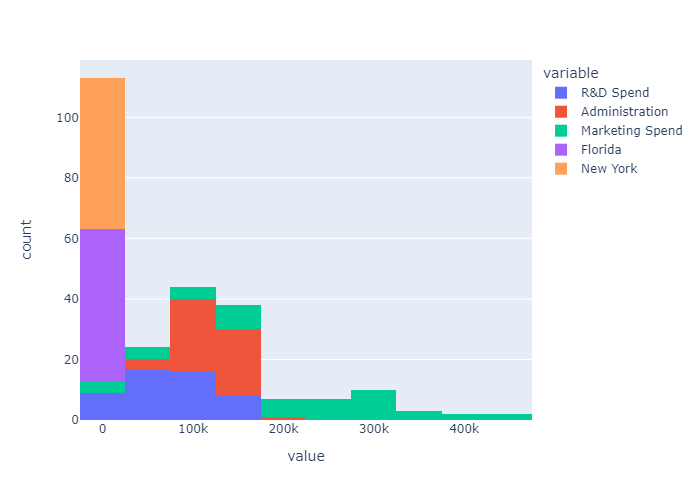

In [11]:
import plotly.express as px
fig = px.histogram(X)
fig.show('png')

## After Scaling - Data is centered

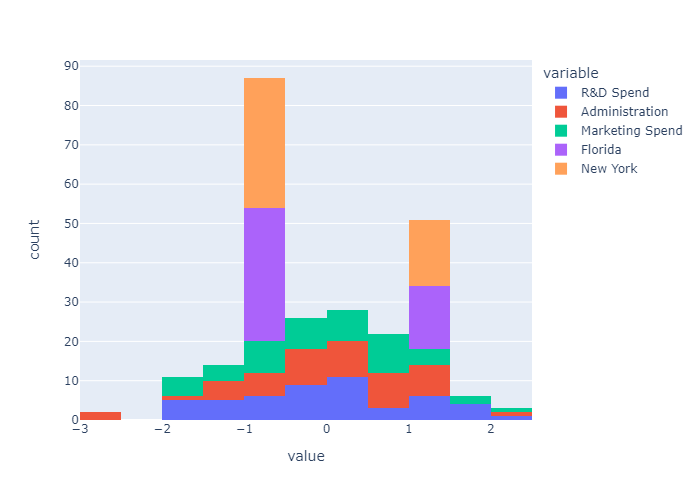

In [12]:
import plotly.express as px
fig = px.histogram(X_new)
fig.show('png')

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 0)

In [14]:
from sklearn.linear_model import LinearRegression
ln_regr = LinearRegression(fit_intercept=True,normalize=True)
ln_regr.fit(X_train,y_train)

LinearRegression(normalize=True)

In [15]:
y_pred = ln_regr.predict(X_test)
from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
score

0.9347068473282425

In [16]:
from sklearn.metrics import mean_squared_error
print("Mean Squared error: %.1f" % mean_squared_error(y_test,y_pred))

Mean Squared error: 83502864.0


In [17]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute error: %.3f' %mean_absolute_error(y_test,y_pred))

Mean Absolute error: 7514.294


In [18]:
simple_lr = pd.DataFrame({'Measure':['Linear_reg_Score',"Mean Squared error",'Mean Absolute error'],
                          'Score':[score,mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred)]},
                         columns=['Measure','Score'])
simple_lr

,Measure,Score
0,Linear_reg_Score,0.935
1,Mean Squared error,"83,502,864.033"
2,Mean Absolute error,"7,514.294"


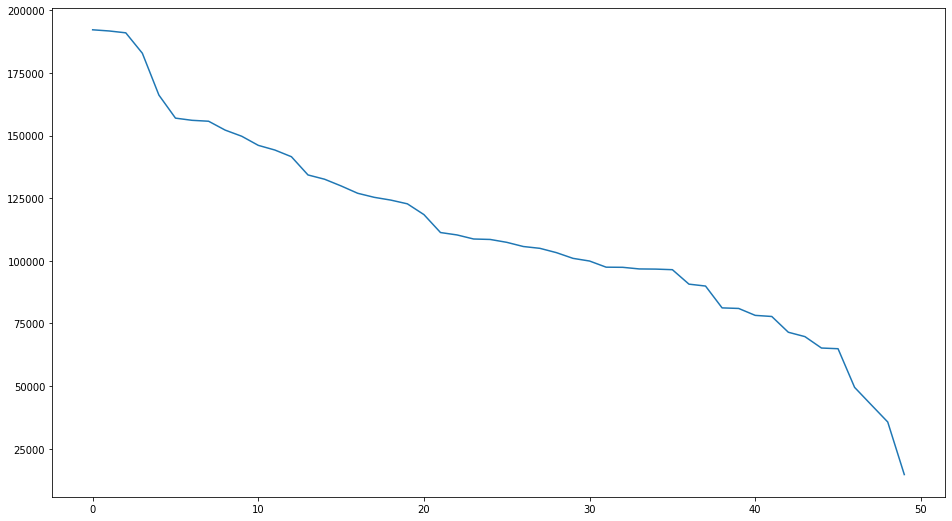

In [19]:
plt.figure(figsize=(16,9))
plt.plot(y)

In [20]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
k_fold = kfold.split(X,y)

In [21]:
scores = []
for k, (train, test) in enumerate(k_fold):
    ln_regr.fit(X.iloc[train, :], y.iloc[train])
    score = ln_regr.score(X.iloc[test, :], y.iloc[test])
    scores.append(score)    
scores

[0.889089099477996,
 -1.000226113202213,
 -0.7895809231263629,
 -0.7603658816487193,
 0.38538399087009634]

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [100,125,150,175,200],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.922,{'normalize': True}
1,lasso,0.926,"{'alpha': 200, 'selection': 'random'}"
2,decision_tree,0.882,"{'criterion': 'mse', 'splitter': 'best'}"


In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,200],'selection':['random']}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 200],
                         'selection': ['random']},
             scoring='neg_mean_squared_error')

In [24]:
y_pred_lasso = lasso_regressor.predict(X_test)

from sklearn.metrics import r2_score
score_lasso=r2_score(y_test,y_pred_lasso)


print(score_lasso)
print(lasso_regressor.best_params_)

0.9390913211540606
{'alpha': 200, 'selection': 'random'}
